In [2]:
%matplotlib notebook

In [78]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import gzip
from os import remove
from os.path import join, exists
from subprocess import call
from matplotlib.ticker import FormatStrFormatter

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]
pd.options.display.float_format = '{:,.3f}'.format

In [377]:
### Edit below to configure evaluation

# Callers to test, and order they are plotted
callers = ['Octopus', 'DeepVariant', 'GATK4', 'Strelka2', 'FreeBayes', 'Platypus']

hard_filter_callers = ['GATK4', 'FreeBayes', 'Platypus']

caller_score_metric = {
    'Octopus': 'INFO.RFQUAL',
    'GATK4': 'QUAL',
    'Strelka2': 'FORMAT.GQX',
    'Platypus': 'QUAL',
    'DeepVariant': 'GQ',
    'FreeBayes': 'GQ'
}

caller_pass_scores = {
    'Octopus': 3.,
    'GATK4': 20.,
    'Strelka2': 3.,
    'Platypus': 20.,
    'DeepVariant': 3.,
    'FreeBayes': 20.
}

experiments = {
    'HG001': ['pFDA.truth', 'pFDA.consistency', 'platinum', 'GIAB.10X'],
    'HG002': ['pFDA.truth', 'GIAB.10X'],
    'HG005': ['GIAB'],
    'Syndip': ['Broad']
}

caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'GATK4': sns.xkcd_rgb["pale red"],
    'Strelka2': sns.xkcd_rgb["amber"],
    'Platypus': sns.xkcd_rgb["greyish"],
    'DeepVariant': sns.xkcd_rgb["faded green"],
    'FreeBayes': sns.xkcd_rgb["dusty purple"]
}

caller_linestyles = {
    'Octopus': '',
    'GATK4': (2,2),
    'Strelka2': (2,2),
    'Platypus': (2,2),
    'DeepVariant': (2,2),
    'FreeBayes': (2,2)
}

rtg_bin = '/Users/dcooke/Genomics/apps/rtg-tools/rtg'
rtg_ref = '/Users/dcooke/Genomics/references/human/GRCh37_SDF'

def get_library_pretty_name(library):
    short_library_name = {
        'platinum': 'Platinum',
        'pFDA.truth': 'Truth',
        'pFDA.consistency': 'Consistency',
        'garvan.xTen': 'Garvan',
        'GIAB.10X': '10X',
    }
    if library in short_library_name:
        return short_library_name[library]
    else:
        return library

def get_plot_title(sample, library, split=False):
    if sample == 'Syndip':
        return sample
    library = get_library_pretty_name(library)
    if split:
        return library + '\n(' + sample + ')'
    else:
        return library + ' (' + sample + ')'

### Do not edit unless changing evaluation directory structure

notebook_dir = os.getcwd()
truth_dir = join(notebook_dir, 'truth')

experiment_samples = experiments.keys()

truth_vcfs, highconf_beds = {}, {}
for sample, _ in experiments.items():
    truth_vcfs[sample]    = join(truth_dir, join(sample, sample + ".vcf.gz"))
    highconf_beds[sample] = join(truth_dir, join(sample, sample + ".bed"))

call_dir = join(notebook_dir, "calls")
eval_dir = join(notebook_dir, "eval")

def get_vcf_path(sample, library, caller):
    return join(join(join(call_dir, sample), library), caller + '.vcf.gz')

def get_eval_dir(sample, library, caller, include_filtered=False):
    result = join(join(eval_dir, sample), library)
    if include_filtered:
        result = join(result, 'all')
    else:
        result = join(result, 'pass')
    return join(result, caller)

caller_vcfs, rtg_eval_dirs = {}, {}
for sample, libraries in experiments.items():
    caller_vcfs[sample] = {}
    rtg_eval_dirs[sample] = {}
    for library in libraries:
        caller_vcfs[sample][library] = {}
        rtg_eval_dirs[sample][library] = {'all': {}, 'pass': {}}
        for caller in callers:
            caller_vcfs[sample][library][caller] = get_vcf_path(sample, library, caller)
            rtg_eval_dirs[sample][library]['all'][caller] = get_eval_dir(sample, library, caller, True)
            rtg_eval_dirs[sample][library]['pass'][caller] = get_eval_dir(sample, library, caller, False)

In [72]:
def run_rtg_vcfeval(caller_vcf, truth_vcf, highconf_regions, out_dir,
                    score_metric=None, include_filtered=False):
    rtg_cmd = [rtg_bin, 'vcfeval', '-t', rtg_ref, '-b', truth_vcf, '--evaluation-regions', highconf_regions, 
               '-c', caller_vcf, '-o', out_dir, '--ref-overlap']
    if score_metric is not None:
        rtg_cmd += ['-f', score_metric]
    if include_filtered:
        rtg_cmd.append('--all-records')
    call(rtg_cmd)

In [83]:
def index(vcf_path):
    call(['tabix', vcf_path])
    return vcf_path + '.tbi'

def remove_vcf(vcf_path):
    remove(vcf_path)
    if exists(vcf_path + '.tbi'):
        remove(vcf_path + '.tbi')

def filter_vcf(in_vcf, metric, threshold, out_vcf):
    cmd = ['bcftools', 'filter', '-i', metric + '>=' + str(threshold), '-Oz', '-o', out_vcf, in_vcf]
    call(cmd)
    index(out_vcf)

def evaluate_caller(caller, sample, library,
                    include_filtered=False,
                    overwrite=False):
    truth_vcf = truth_vcfs[sample]
    truth_bed = highconf_beds[sample]
    caller_vcf = caller_vcfs[sample][library][caller]
    if include_filtered:
        out_dir = rtg_eval_dirs[sample][library]['all'][caller]
    else:
        out_dir = rtg_eval_dirs[sample][library]['pass'][caller]
    if exists(out_dir):
        if type(overwrite) is not bool:
            overwrite = caller in overwrite
        if overwrite:
            print('Overwriting ' + out_dir)
            shutil.rmtree(out_dir)
        else:
            print('Found existing evaluation: ' + out_dir)
            return
    if not include_filtered and caller in hard_filter_callers:
        tmp_vcf = caller_vcf.replace('.vcf', '.filtered.tmp.vcf')
        filter_vcf(caller_vcf, caller_score_metric[caller], caller_pass_scores[caller], tmp_vcf)
        run_rtg_vcfeval(tmp_vcf, truth_vcf, truth_bed, out_dir, 
                        score_metric=caller_score_metric[caller])
        remove_vcf(tmp_vcf)
    else:
        run_rtg_vcfeval(caller_vcf, truth_vcf, truth_bed, out_dir, 
                        score_metric=caller_score_metric[caller],
                        include_filtered=include_filtered)

def evaluate_callers(callers, sample, library, include_filtered=False, overwrite=False):
    for caller in callers:
        evaluate_caller(caller, sample, library, include_filtered=include_filtered, overwrite=overwrite)

def run_full_evaluation(include_filtered=False, overwrite=False):
    for sample, libraries in experiments.items():
        for library in libraries:
            evaluate_callers(callers, sample, library, include_filtered=include_filtered, overwrite=overwrite)

In [8]:
def read_caller_performance_summary(caller, rtg_eval_dir):
    summary_fname = join(rtg_eval_dir, 'summary.txt')
    with open(summary_fname) as f:
        lines = f.readlines()
        header, stats = lines[0].strip().split(), lines[-1].strip().split()
        assert len(header) == len(stats)
        result = pd.DataFrame([[caller]], columns=['caller'])
        for field, stat in zip(header, stats):
            if field != "Threshold":
                result[field] = stat
        return result
    return None

def read_performance_summaries(rtg_eval_dirs):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_caller_performance_summary(caller, rtg_eval_dir))
    return pd.concat(caller_dfs)

In [389]:
def read_rtg_roc_header(rtg_roc):
    if rtg_roc.endswith('.gz'):
        f = gzip.open(rtg_roc, 'rt')
    else:
        f = open(rtg_roc)
    result = None
    for line in f:
        if line.startswith('#'):
            result = line.strip()[1:].split('\t')
        else:
            break
    return result

def get_rtg_roc_file(rtg_eval_dir, variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        roc_name = 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        roc_name = 'non_snp_roc.tsv.gz'
    else:
        roc_name = 'weighted_roc.tsv.gz'
    return join(rtg_eval_dir, roc_name)

def read_rtg_roc(rtg_eval_dir, variant_type='all', caller=None):
    rtg_roc = get_rtg_roc_file(rtg_eval_dir, variant_type)
    result = pd.read_csv(rtg_roc, sep='\t', comment='#')
    result.columns = read_rtg_roc_header(rtg_roc)
    if caller is not None:
        result['caller'] = caller
    result.rename(columns={'sensitivity': 'recall'}, inplace=True)
    return result

def read_rtg_rocs(rtg_eval_dirs, variant_type='all'):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_rtg_roc(rtg_eval_dir, variant_type=variant_type, caller=caller))
    return pd.concat(caller_dfs)

def add_precision_recall(ax, df, ylim=None, xlim=None, despine=True,
                         title=None, legend=True, legend_title=False,
                         y_format='%.3f', x_format='%.3f',
                         ylabel='Precision (PPV)', xlabel='Recall'):
    if legend:
        legend = 'brief'
    sns.lineplot(x="recall", y="precision", hue="caller", style="caller",
                 palette=caller_colours, dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def add_marker(ax, x, y, colour, style='o', size=50):
    sns.regplot(x=np.array([x]), y=np.array([y]), scatter=True, fit_reg=False,
                marker=style, color=colour, scatter_kws={"s": size}, ax=ax)

def find_marker(df, caller, score):
    df = df.replace('None', 0)
    df['score'] = df['score'].apply(pd.to_numeric)
    for tol in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]:
        lines = df[(df.caller == caller) & np.isclose(df.score, score, atol=tol)]
        if lines.shape[0] > 0:
            break
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['recall'].iloc[0]), float(lines['precision'].iloc[0])

def plot_precision_recall(df, ylim=None, xlim=None,
                          marker_scores=None,
                          title=None, legend_out=True,
                          y_format='%.3f', x_format='%.3f',
                          save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_precision_recall(ax, df, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format, title=title)
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                add_marker(ax, marker_x, marker_y, caller_colours[caller])
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_precision_recalls(axes, dfs, titles, ylims=None, xlims=None, xlabel='Recall'):
    for title, ax in zip(titles, axes):
        ylim, xlim = None, None
        if ylims is not None:
            ylim = ylims[title]
        if xlims is not None:
            xlim = xlims[title]
        add_precision_recall(ax, dfs[title], ylim=ylim, xlim=xlim,
                             title=title, legend_title=True, xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def add_markers(axes, marker_scores, dfs, titles):
    for title, ax in zip(titles, axes):
        df = dfs[title]
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                add_marker(ax, marker_x, marker_y, caller_colours[caller], size=25)

def plot_precision_recalls(dfs, xlims=None, ylims=None, marker_scores=None,
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    subplot_titles = list(dfs.keys())
    n_subplots = len(subplot_titles)
    nrows, ncols = int(n_subplots/4), min(n_subplots, 4)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    for i in range(nrows - 1):
        add_precision_recalls(axes.flat[i*ncols:i*ncols+ncols], dfs, subplot_titles[i*ncols:i*ncols+ncols],
                              ylims=ylims, xlims=xlims, xlabel='')
    add_precision_recalls(axes.flat[-ncols:], dfs, subplot_titles[-ncols:],
                          ylims=ylims, xlims=xlims)
    if marker_scores is not None:
        add_markers(axes.flat, marker_scores, dfs, subplot_titles)
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [17]:
def calculate_precision_recall_auc(pr_df):
    precisions, recalls = list(pr_df["precision"]), list(pr_df["recall"])
    assert len(precisions) == len(recalls)
    result = 0.
    prev_precision, prev_recall = precisions[0], recalls[0]
    for precision, recall in zip(precisions[1:], recalls[1:]):
        result += (recall - prev_recall) * (prev_recall + recall) / 2
        prev_precision, prev_recall = precision, recall
    return result

In [382]:
def read_performance_summaries_helper(sample, replicat, filtering='pass'):
    return read_performance_summaries(rtg_eval_dirs[sample][replicat][filtering])

def read_experiment_performance_summaries(experiments, filtering='pass'):
    dfs = []
    for (sample, libraries) in experiments.items():
        for library in libraries:
            for caller in callers:
                caller_eval_dir = rtg_eval_dirs[sample][library][filtering][caller]
                if exists(caller_eval_dir):
                    df = read_caller_performance_summary(caller, caller_eval_dir)
                    df.insert(0, 'Sample', sample)
                    df.insert(1, 'Library', library)
                    dfs.append(df)
    return pd.concat(dfs)

def read_all_performance_summaries(filtering='pass'):
    return read_experiment_performance_summaries(experiments, filtering=filtering)

def plot_precision_recall_helper(sample, library, filtering='pass', variant_type='all',
                                 pass_markers=True,
                                 ylim=None, xlim=None,
                                 y_format='%.3f', x_format='%.3f',
                                 title=None, save=None):
    marker_scores = None
    if filtering == 'all' and pass_markers:
        marker_scores = caller_pass_scores
    plot_precision_recall(read_rtg_rocs(rtg_eval_dirs[sample][library][filtering], variant_type=variant_type),
                          ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format, 
                          marker_scores=marker_scores, title=title, save=save)

def plot_precision_recalls_helper(tests, limits, pass_markers=True, save=None, save_format='pdf'):
    assert len(tests) == len(limits)
    rocs, xlims, ylims = {}, {}, {}
    for (sample, library, filtering), (xlim, ylim) in zip(tests, limits):
        title = get_plot_title(sample, library)
        rocs[title] = read_rtg_rocs(rtg_eval_dirs[sample][library][filtering])
        xlims[title], ylims[title] = xlim, ylim
    marker_scores = None
    if filtering == 'all' and pass_markers:
        marker_scores = caller_pass_scores
    plot_precision_recalls(rocs, xlims, ylims, marker_scores=marker_scores, save=save, save_format=save_format)

In [334]:
def plot_f1_scores(experiments, filtering='pass', miny=0.9, save=None, save_format='pdf'):
    summaries = read_experiment_performance_summaries(experiments, filtering=filtering)
    summaries['Experiment'] = summaries.apply(lambda row: get_plot_title(row['Sample'], row['Library'], split=True), axis=1)
    summaries['F-measure'] = summaries['F-measure'].astype(float)
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(12, 7))
    g = sns.barplot(x="Experiment", y="F-measure", hue="caller",
                    palette=caller_colours, ci=None, data=summaries,
                    ax=ax)
    sns.despine(ax=ax)
    ax.set(xlabel='')
    ax.set_ylim(miny, 1.)
    handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                     loc='upper center', #bbox_to_anchor=(0.5, 1.0),
                     borderaxespad=0, ncol=len(labels))
    ax.legend_.remove()
    if save is not None:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

def plot_fp_counts(experiments, filtering='pass', maxy=None, save=None, save_format='pdf'):
    summaries = read_experiment_performance_summaries(experiments, filtering=filtering)
    summaries['Experiment'] = summaries.apply(lambda row: get_plot_title(row['Sample'], row['Library'], split=True), axis=1)
    summaries['False positives'] = summaries['False-pos'].astype(int)
    fig, ax = plt.subplots(figsize=(12, 6))
    g = sns.barplot(x="Experiment", y="False positives", hue="caller",
                    palette=caller_colours, ci=None, data=summaries)
    if maxy is not None:
        ax.set_ylim(0, maxy)
    ax.set(xlabel='')
    handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                     loc='upper center', #bbox_to_anchor=(0.5, 1.0),
                     borderaxespad=0, ncol=len(labels))
    ax.legend_.remove()
    if save is not None:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

<IPython.core.display.Javascript object>


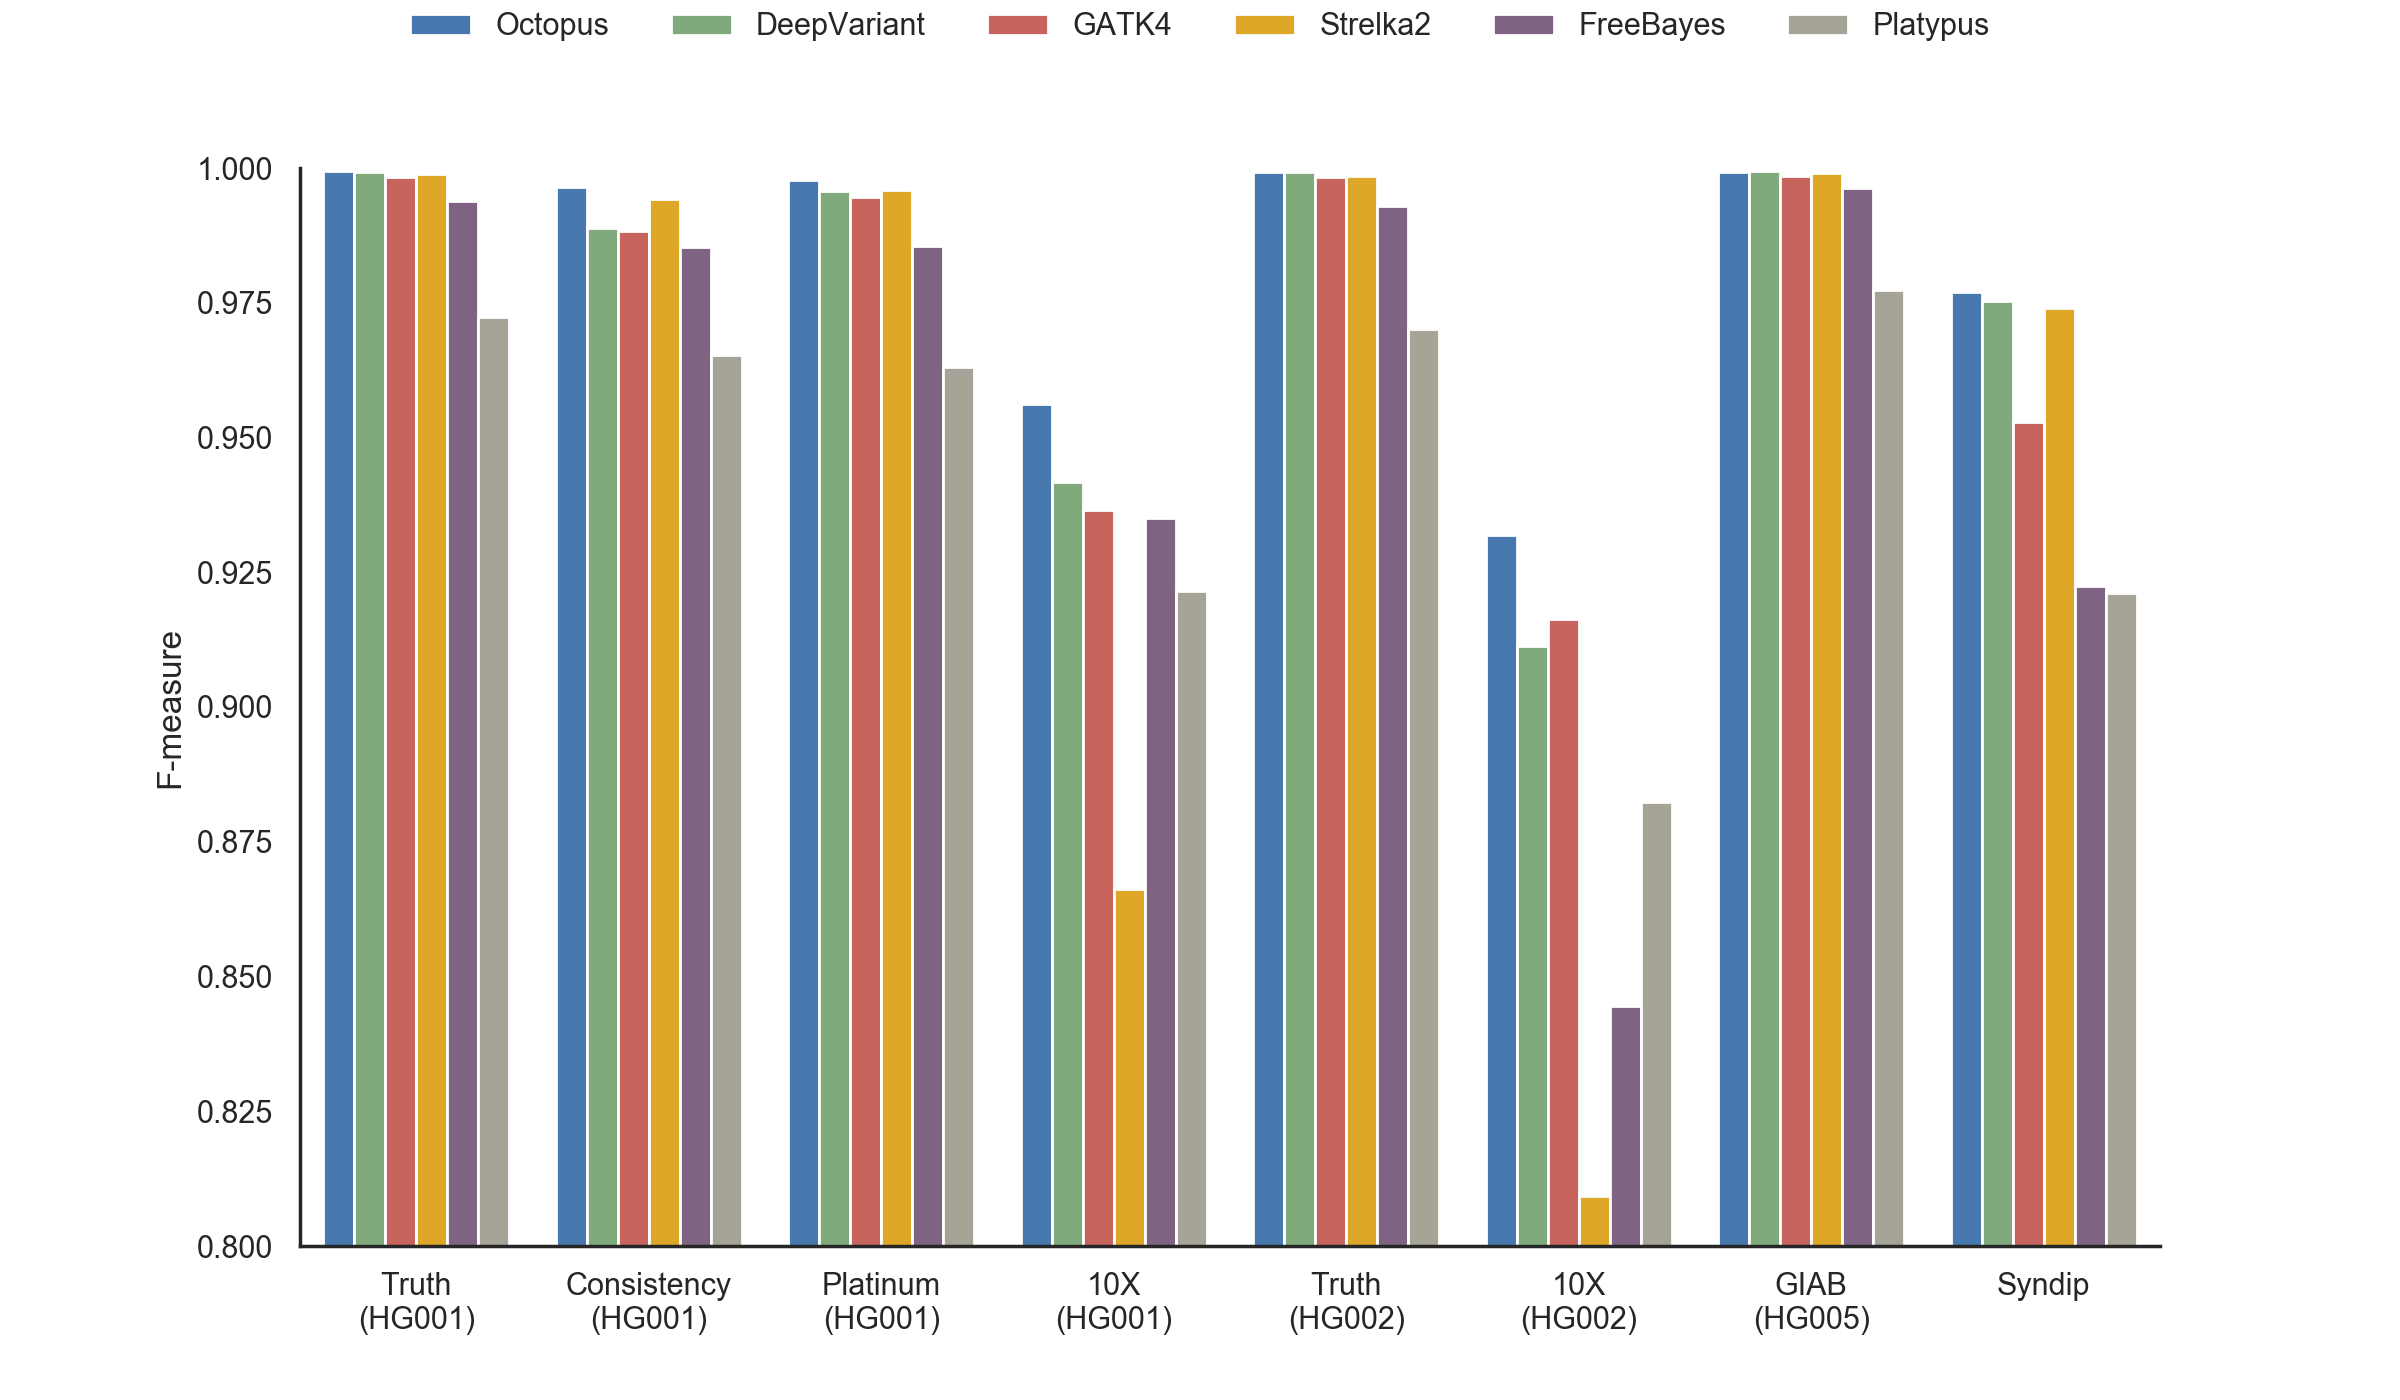

In [366]:
plot_f1_scores(experiments, miny=0.8, save="/Users/dcooke/Documents/octopus-paper/figures/F-Measures.pdf")

<IPython.core.display.Javascript object>


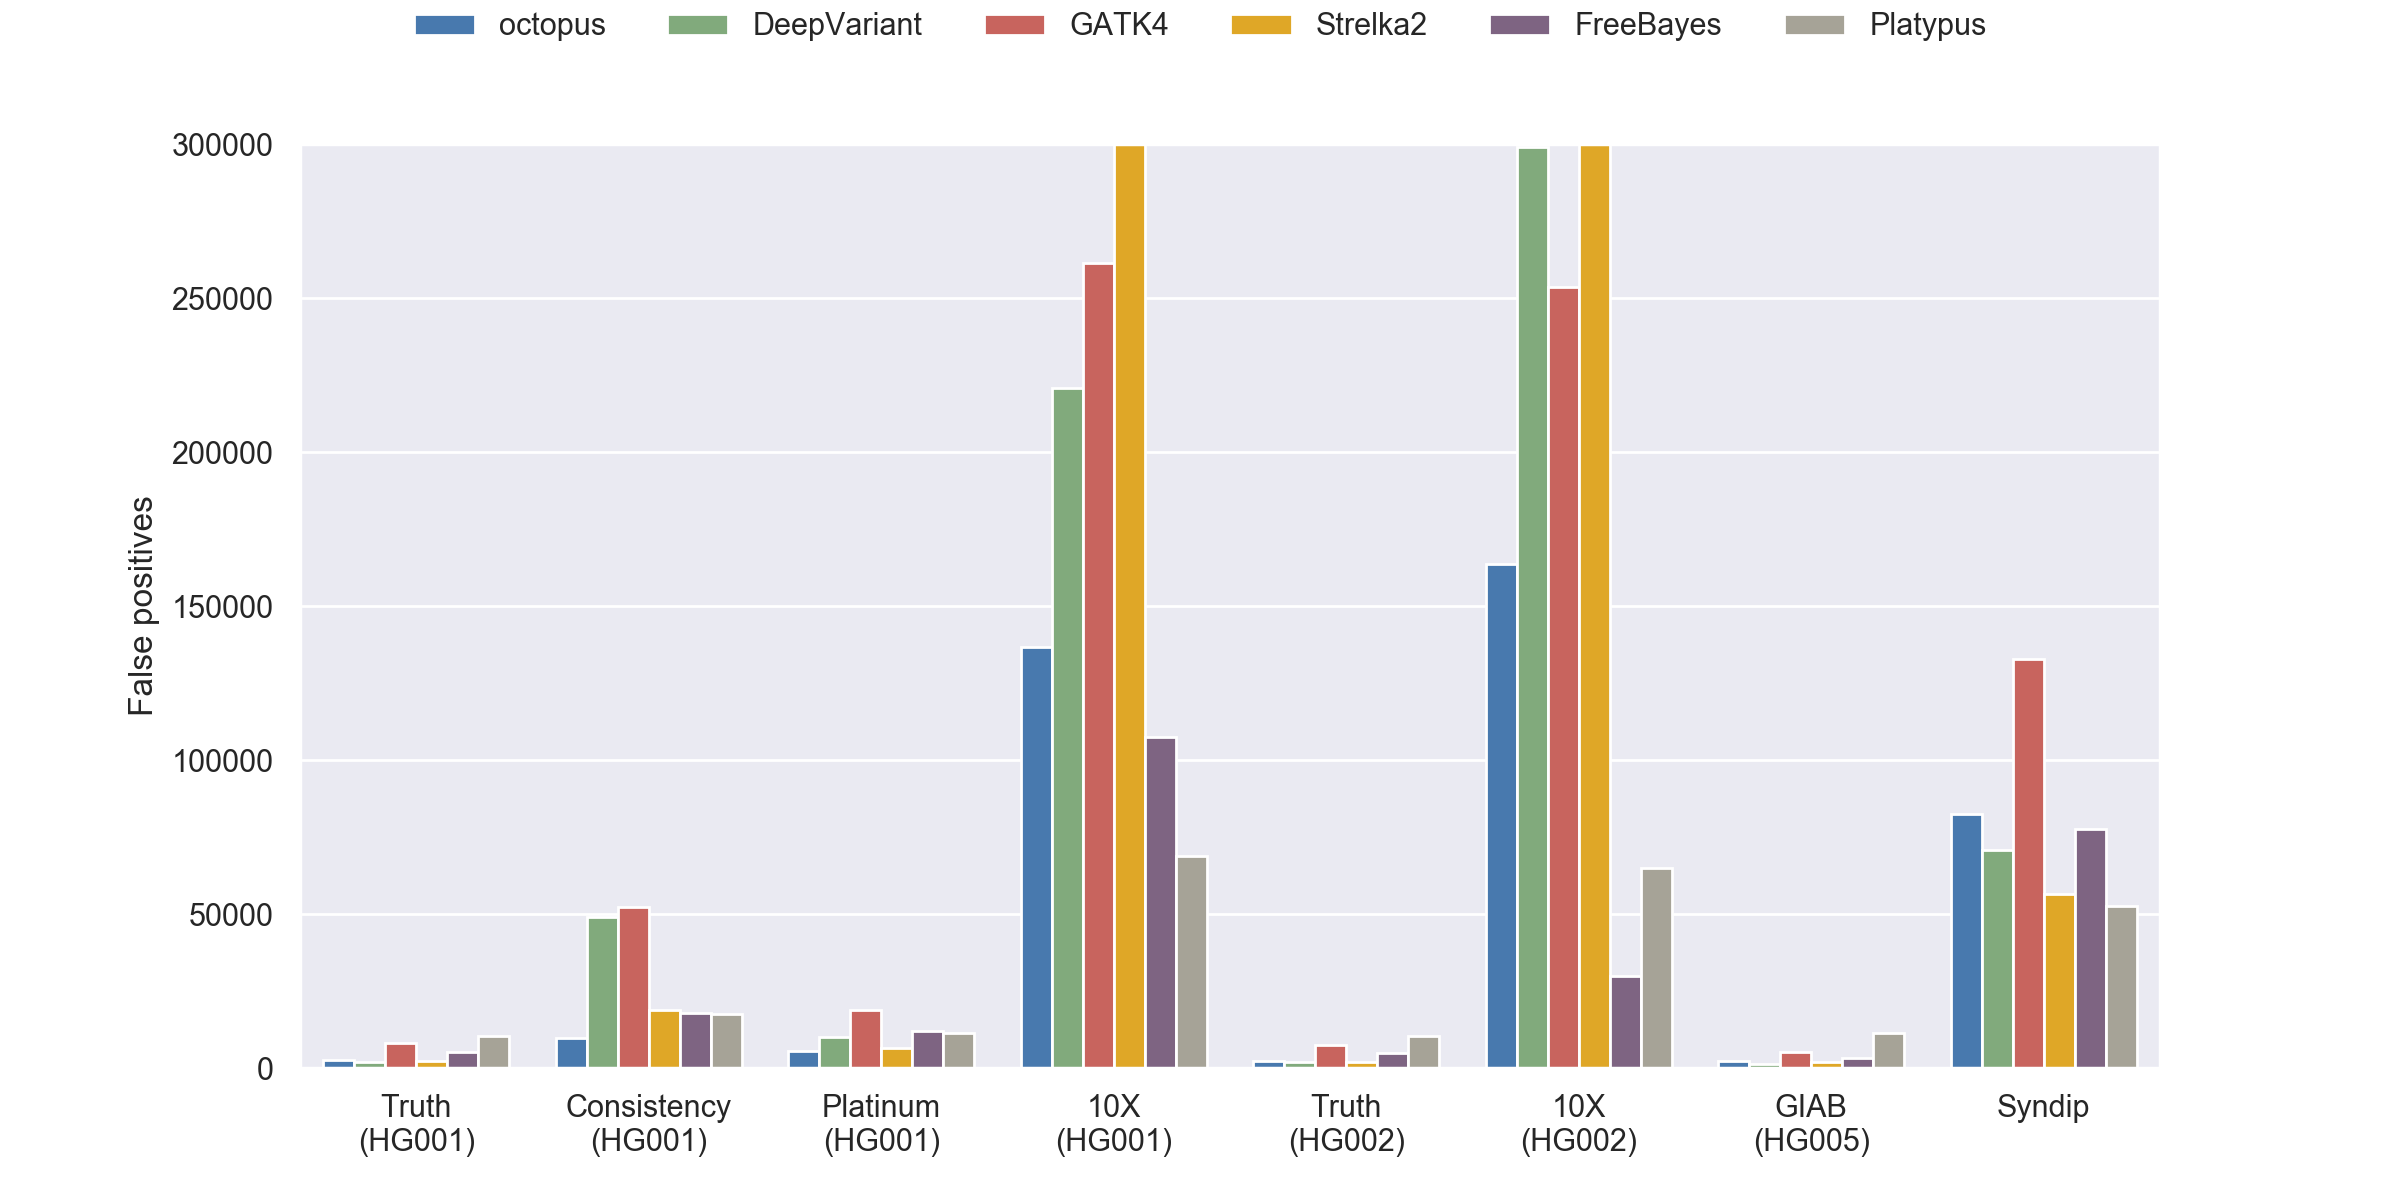

In [103]:
plot_fp_counts(experiments, maxy=300000, save="/Users/dcooke/Documents/octopus-paper/figures/false-positives.pdf")

In [43]:
evaluate_callers(callers, 'HG005', 'GIAB', include_filtered=False)
evaluate_callers(callers, 'HG005', 'GIAB', include_filtered=True)

Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/pass/octopus
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/pass/DeepVariant
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/pass/GATK4
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/pass/Strelka2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/pass/Platypus
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/all/octopus
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/all/DeepVariant
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/all/GATK4
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/HG005/GIAB/all/Strelka2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/germline/eval/H

In [379]:
summary_df = read_all_performance_summaries('pass')
with open('/Users/dcooke/Documents/octopus-paper/supplementary/tables/germline_summary.tex', 'w') as f:
    summary_df['Library'] = summary_df.apply(lambda row: get_library_pretty_name(row['Library']), axis=1)
    f.write(summary_df.to_latex(index=False))

<IPython.core.display.Javascript object>


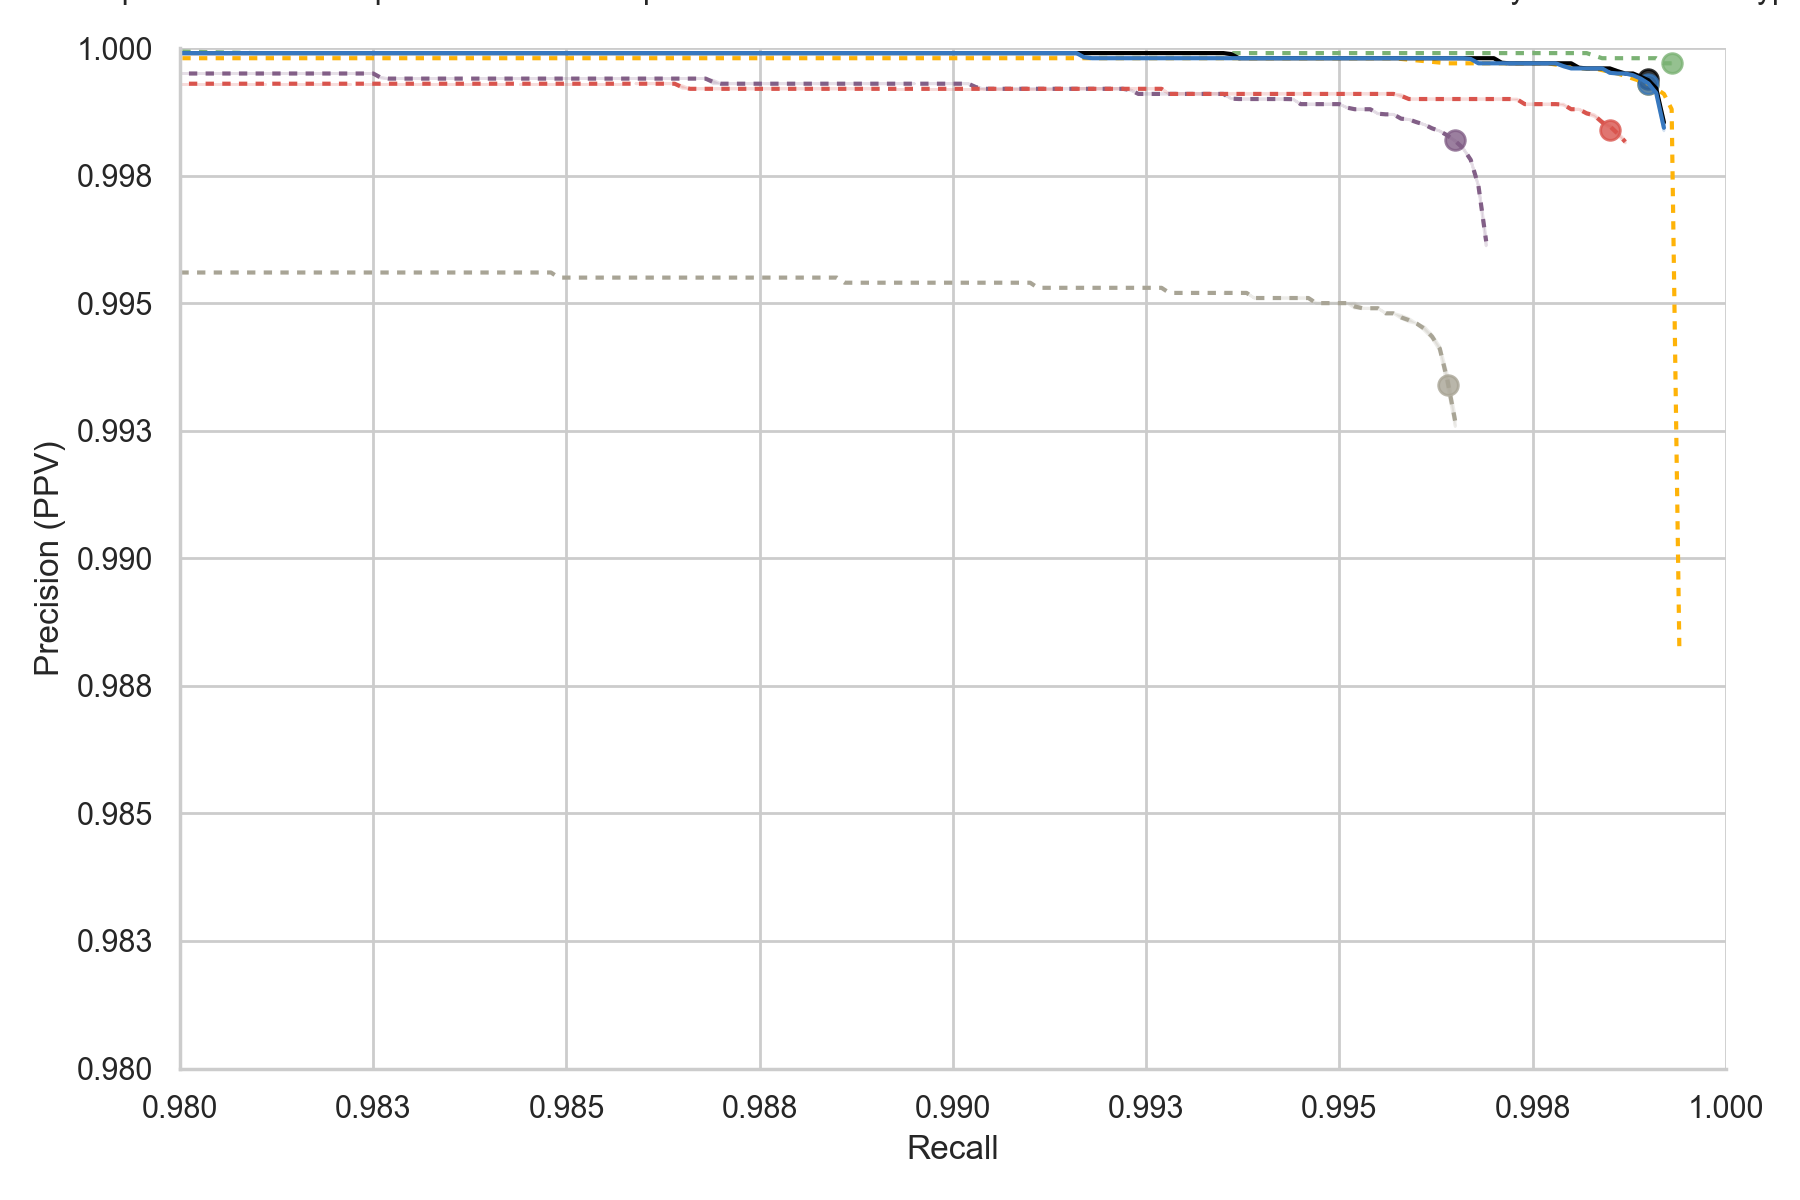

In [16]:
plot_precision_recall_helper('HG005', 'GIAB', 'all', ylim=(0.98, 1.), xlim=(0.98, 1.))

<IPython.core.display.Javascript object>


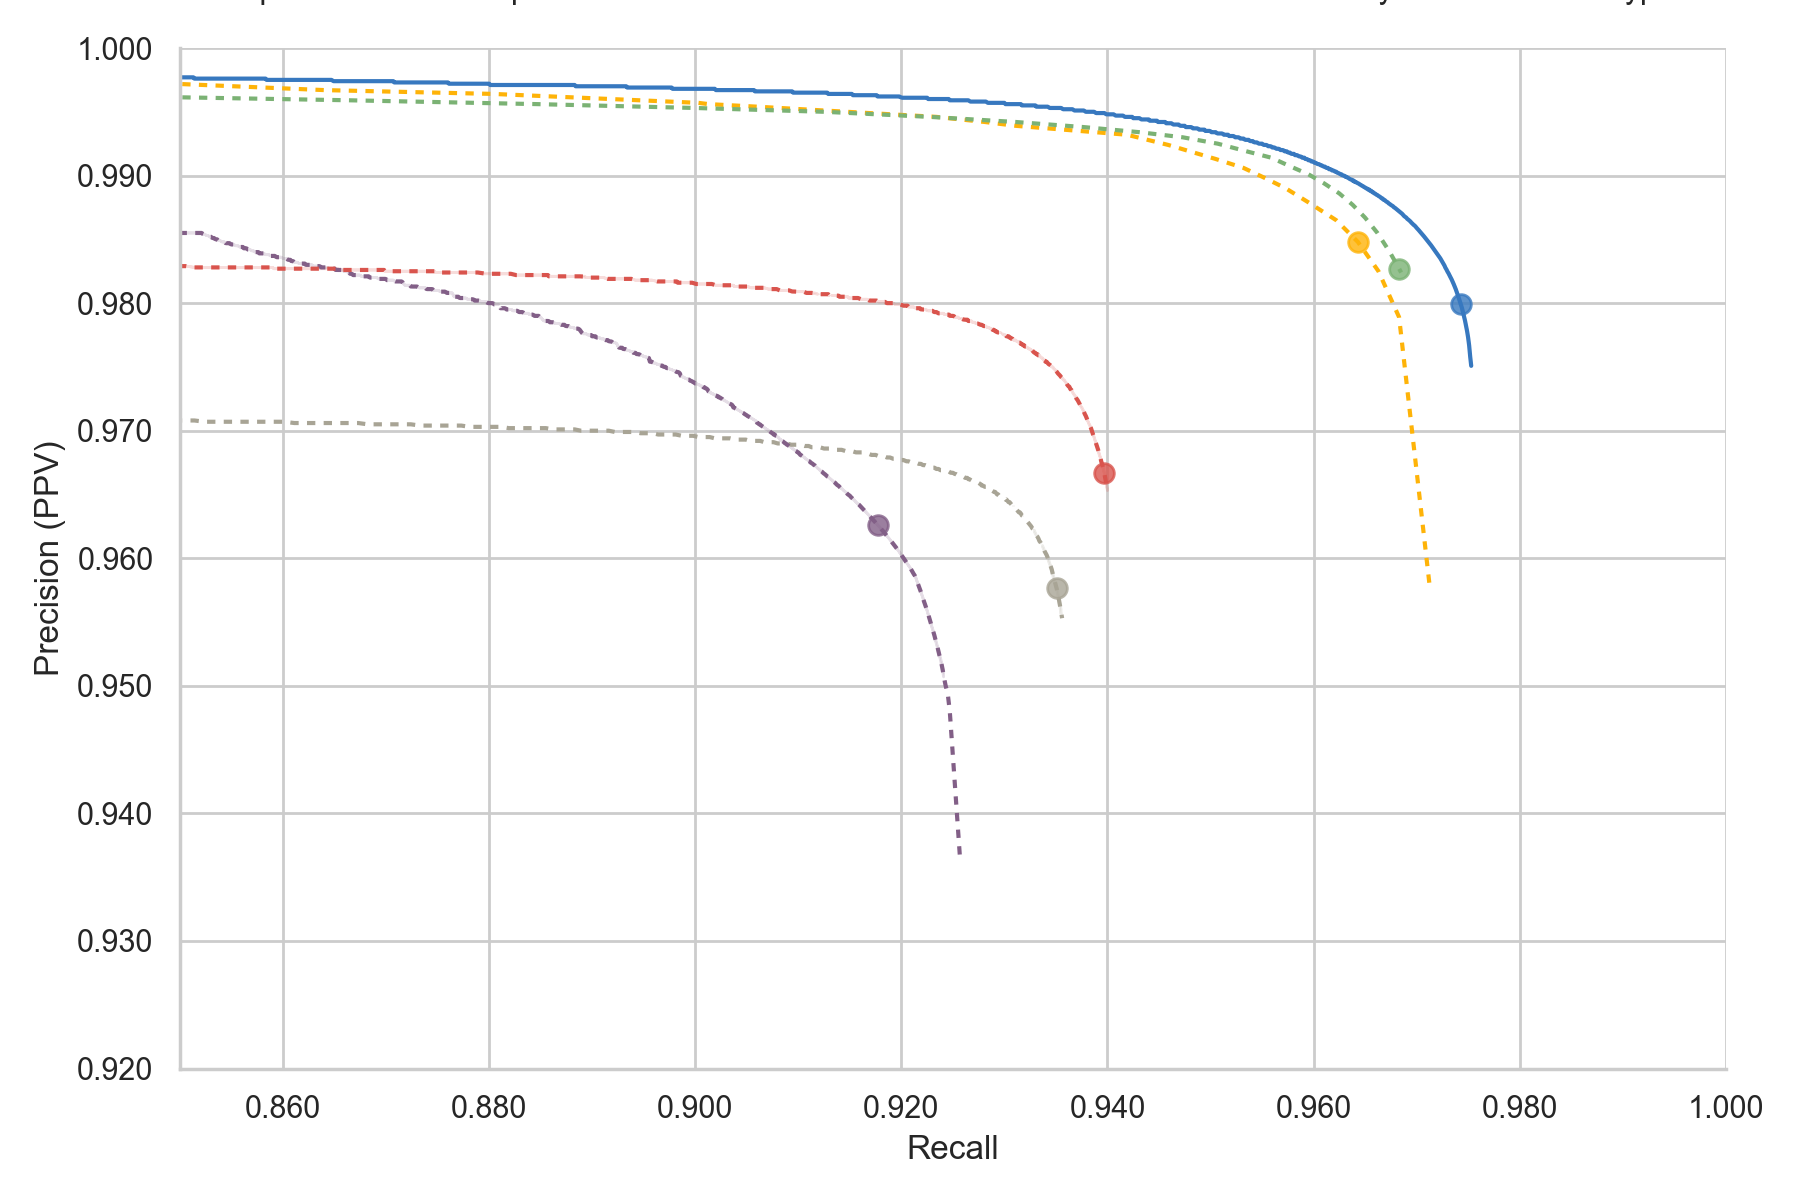

In [390]:
plot_precision_recall_helper('Syndip', 'Broad', 'all', ylim=(0.92, 1.), xlim=(0.85, 1.))

<IPython.core.display.Javascript object>


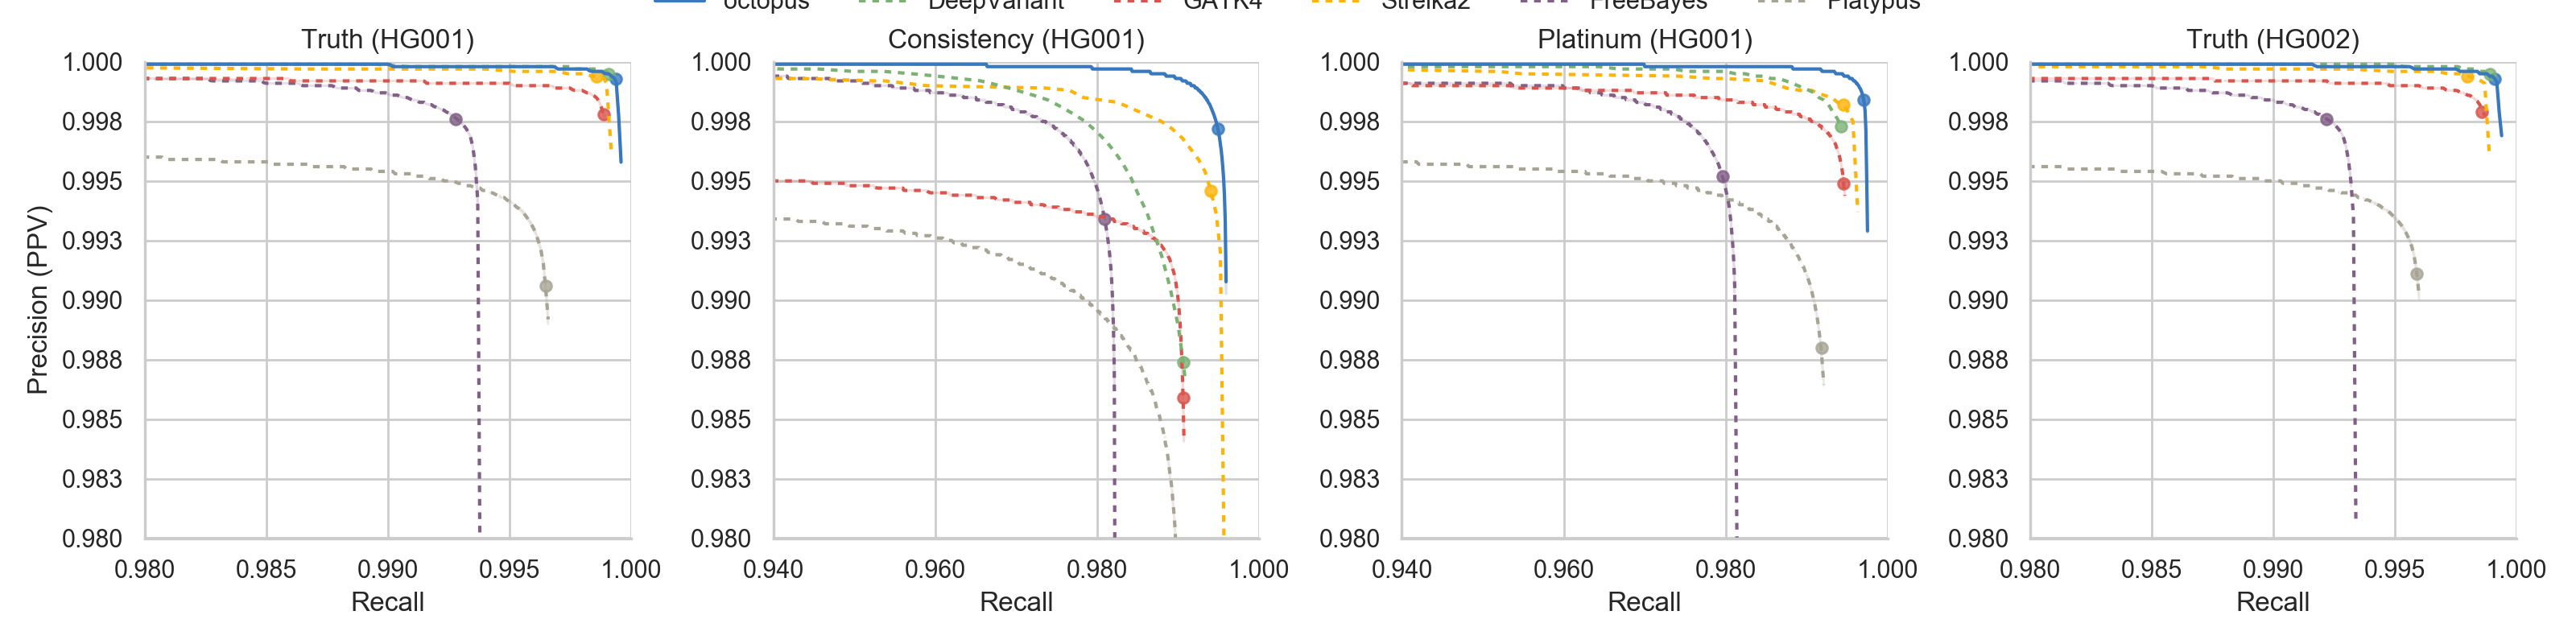

In [417]:
plot_precision_recalls_helper([('HG001', 'pFDA.truth', 'all'),
                               ('HG001', 'pFDA.consistency', 'all'),
                               ('HG001', 'platinum', 'all'),
                               ('HG002', 'pFDA.truth', 'all')],
                              [((0.98, 1.), (0.98, 1.)),
                               ((0.94, 1.), (0.98, 1.)),
                               ((0.94, 1.), (0.98, 1.)),
                               ((0.98, 1.), (0.98, 1.))],
                              save='/Users/dcooke/Documents/octopus-paper/figures/giab_unfiltered_precision_recals.pdf')

<IPython.core.display.Javascript object>


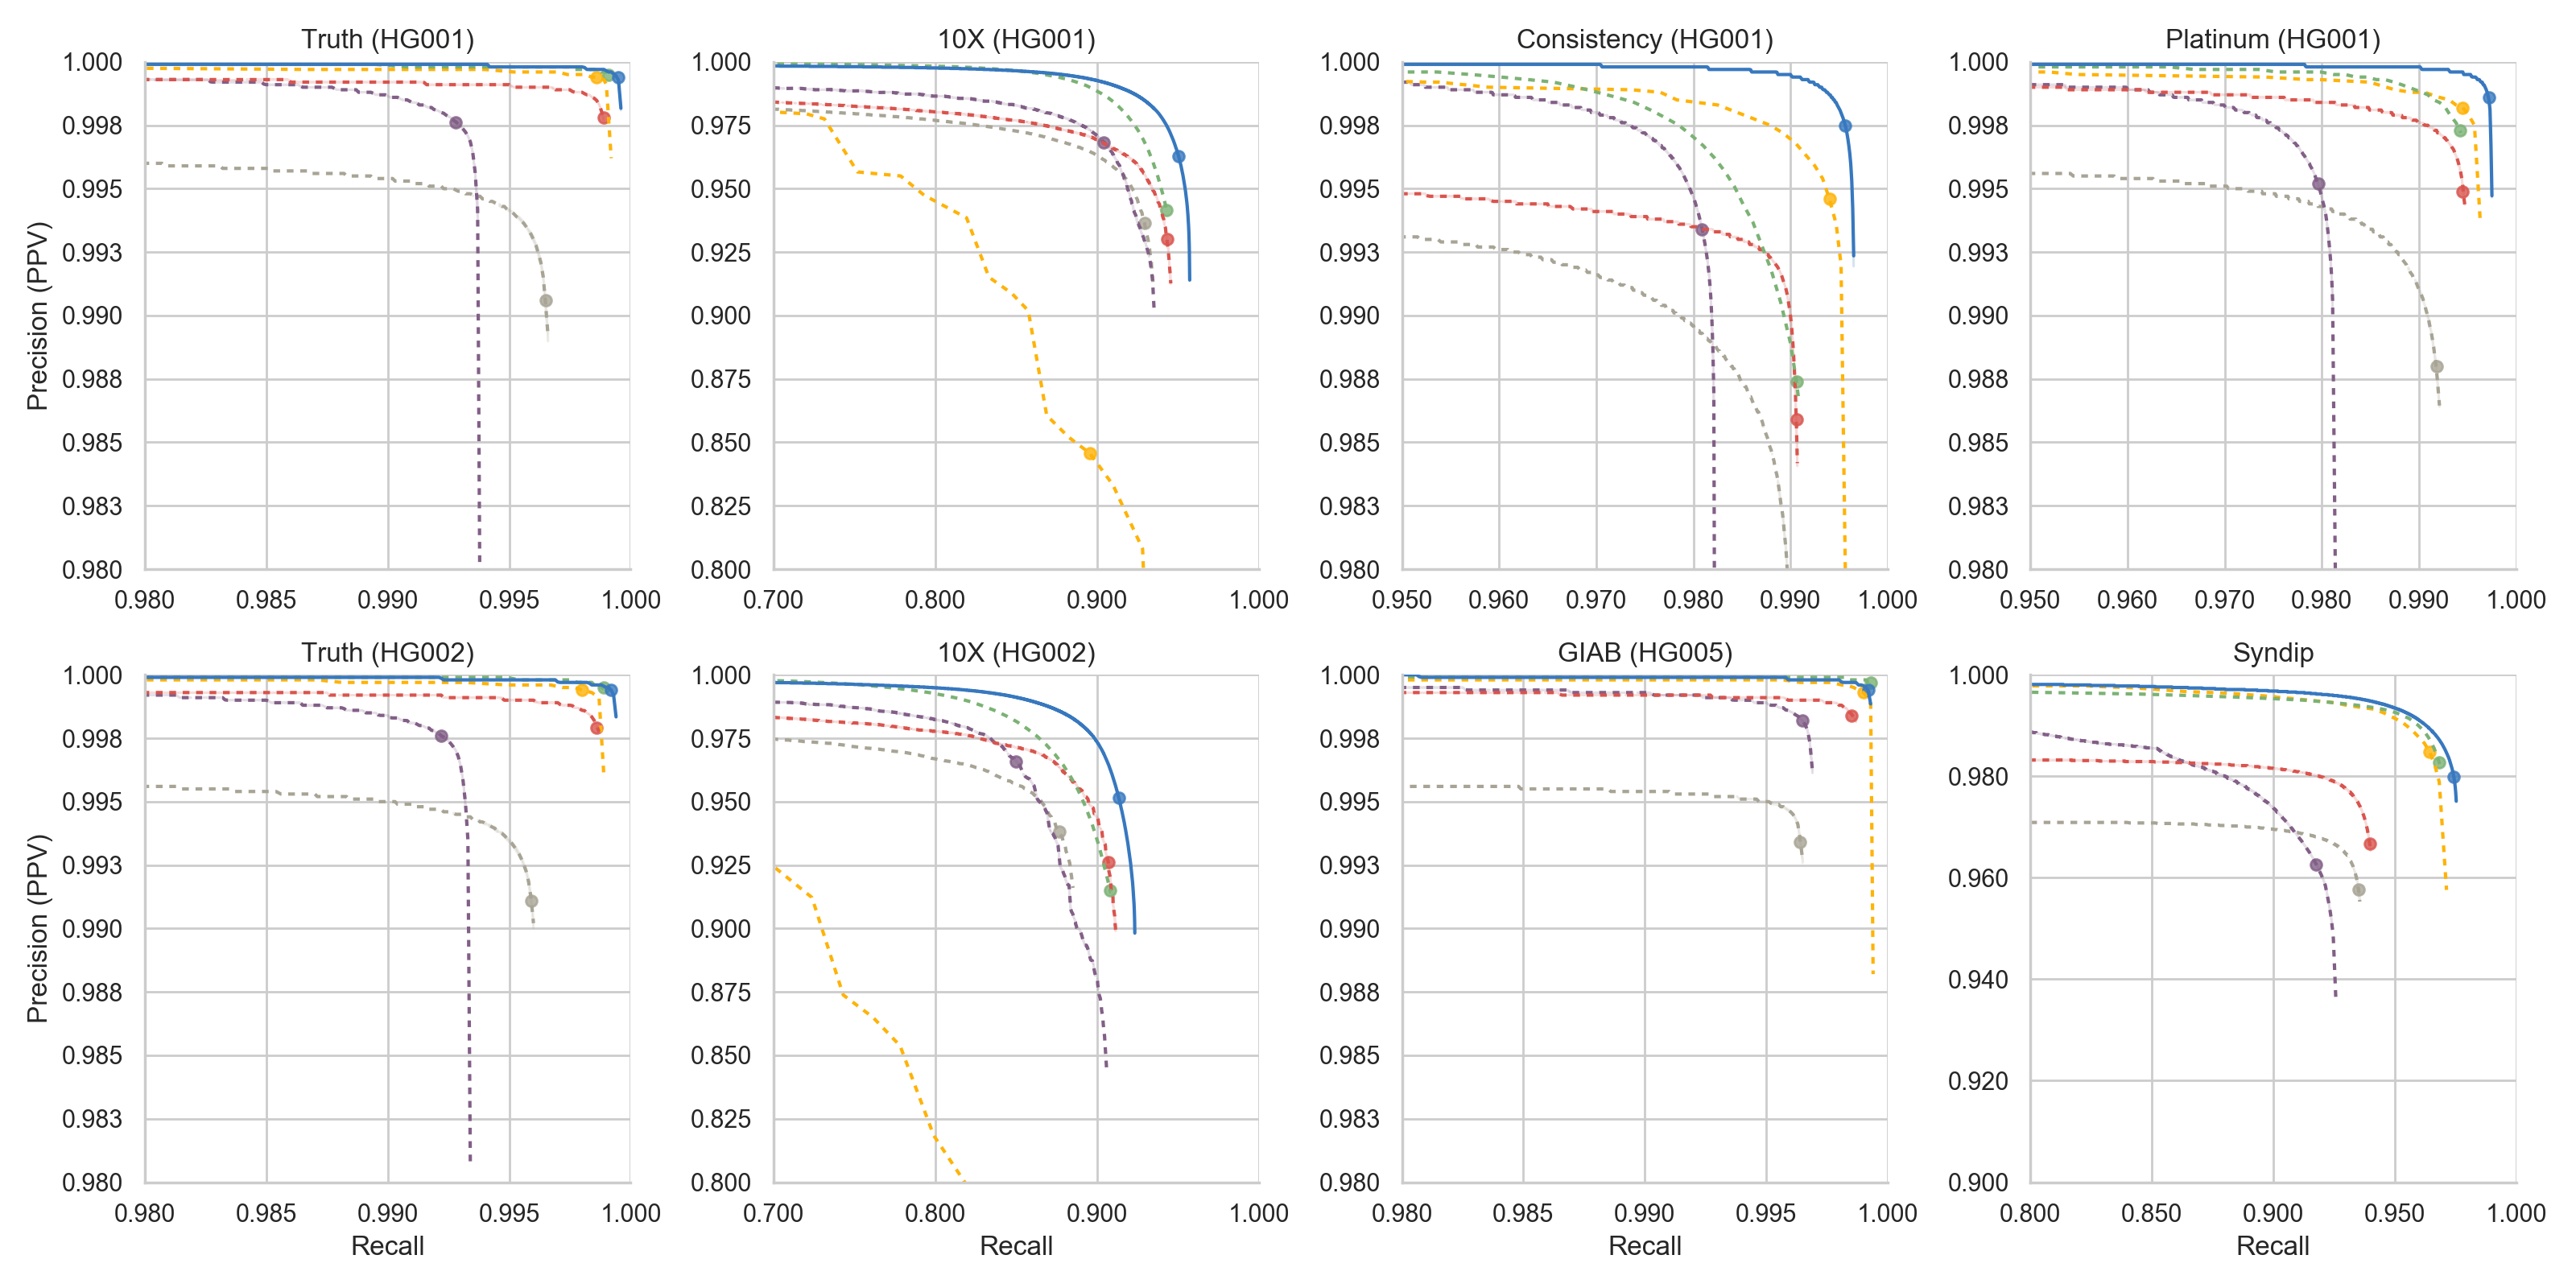

In [368]:
plot_precision_recalls_helper([('HG001', 'pFDA.truth', 'all'),
                               ('HG001', 'GIAB.10X', 'all'),
                               ('HG001', 'pFDA.consistency', 'all'),
                               ('HG001', 'platinum', 'all'),
                               ('HG002', 'pFDA.truth', 'all'),
                               ('HG002', 'GIAB.10X', 'all'),
                               ('HG005', 'GIAB', 'all'),
                               ('Syndip', 'Broad', 'all')
                              ],
                              [((0.98, 1.), (0.98, 1.)),
                               ((0.7, 1.), (0.8, 1.)),
                               ((0.95, 1.), (0.98, 1.)),
                               ((0.95, 1.), (0.98, 1.)),
                               ((0.98, 1.), (0.98, 1.)),
                               ((0.7, 1.), (0.8, 1.)),
                               ((0.98, 1.), (0.98, 1.)),
                               ((0.8, 1.), (0.9, 1.))
                              ], save='/Users/dcooke/Documents/octopus-paper/figures/giab_unfiltered_precision_recals.pdf')

In [354]:
import pysam as ps

def count_records(vcf_path, matches):
    vcf = ps.VariantFile(vcf_path)
    return sum(matches(record) for record in vcf)

def is_indel(ref, alt, min_size=None, max_size=None):
    if min_size is None and max_size is None:
        return len(alt) != len(ref)
    else:
        size = abs(len(alt) - len(record.ref))
        if min_size is None:
            return size <= max_size
        elif max_size is None:
            return size >= min_size
        else:
            return min_size <= size <= max_size

def has_indel(record, min_size=None):
    return any(is_indel(record.ref, alt, min_size=min_size) for alt in record.alts)

def count_indel_records(vcf_path, min_size=None):
    return count_records(vcf_path, lambda record: has_indel(record, min_size))

def count_alt_indels(record, min_size=None):
    return sum(is_indel(record.ref, alt) for alt in record.alts)

def count_called_indels(vcf_path, min_size=None):
    vcf = ps.VariantFile(vcf_path)
    return sum(count_alt_indels(record, min_size=min_size) for record in vcf)

def subset_vcf(in_vcf_path, bed_regions, out_vcf_path):
    cmd = ['bcftools', 'view', '-T', bed_regions, '-Oz', '-o', out_vcf_path, in_vcf_path]
    call(cmd)
    index(out_vcf_path)

def read_indel_size_distribution(vcf_path, bed_regions=None):
    if bed_regions is not None:
        tmp_vcf = vcf_path.replace('.vcf', '.tmp.vcf')
        subset_vcf(vcf_path, bed_regions, tmp_vcf)
        res = read_indel_size_distribution(tmp_vcf)
        remove_vcf(tmp_vcf)
        return res
    vcf = ps.VariantFile(vcf_path)
    dist = {}
    min_size, max_size = None, None
    for record in vcf:
        for alt in record.alts:
            if is_indel(record.ref, alt):
                size = len(alt) - len(record.ref)
                if size in dist:
                    dist[size] += 1
                else:
                    dist[size] = 1
                if min_size is None:
                    min_size = size
                    max_size = min_size
                else:
                    min_size = min(min_size, size)
                    max_size = max(max_size, size)
    if max_size is not None:
        sizes = list(range(min_size, max_size + 1))
    else:
        sizes = []
    counts = [dist[size] if size in dist else 0 for size in sizes]
    return sizes, counts, dist

def read_indel_size_distribution_df(caller, vcf_path, bed_regions=None):
    sizes, counts, _ = read_indel_size_distribution(vcf_path, bed_regions=bed_regions)
    result = pd.DataFrame({'caller': caller, 'size': sizes, 'count': counts})
    result[['size', 'count']] = result[['size', 'count']].astype(int)
    return result

def read_caller_indel_stats(caller, rtg_eval_dir, bed_regions=None):
    tps = join(rtg_eval_dir, 'tp.vcf.gz')
    return read_indel_size_distribution_df(caller, tps, bed_regions=bed_regions)

def read_truth_indel_stats_df(rtg_eval_dir, bed_regions=None):
    tps = join(rtg_eval_dir, 'tp-baseline.vcf.gz')
    tp_sizes, _, tp_dist = read_indel_size_distribution(tps, bed_regions=bed_regions)
    fns = join(rtg_eval_dir, 'fn.vcf.gz')
    fn_sizes, _, fn_dist = read_indel_size_distribution(fns, bed_regions=bed_regions)
    min_size, max_size = min(tp_sizes[0], fn_sizes[0]), max(tp_sizes[-1], fn_sizes[-1])
    if max_size is not None:
        sizes = list(range(min_size, max_size + 1))
    else:
        sizes = []
    dist = {}
    for size in sizes:
        dist[size] = 0
        if size in tp_dist:
            dist[size] += tp_dist[size]
        if size in fn_dist:
            dist[size] += fn_dist[size]
    counts = [dist[size] if size in dist else 0 for size in sizes]
    result = pd.DataFrame({'caller': 'Truth', 'size': sizes, 'count': counts})
    result[['size', 'count']] = result[['size', 'count']].astype(int)
    return result

def read_indel_stats(sample, library, rtg_eval_dirs, add_truth=True, bed_regions=None):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_caller_indel_stats(caller, rtg_eval_dir, bed_regions=bed_regions))
            if add_truth:
                caller_dfs.append(read_truth_indel_stats_df(rtg_eval_dir, bed_regions=bed_regions))
                add_truth = False
    res = pd.concat(caller_dfs).fillna(0.)
    res['Sample'] = sample
    res['Library'] = library
    return res

def read_all_indel_stats(add_truth=True, filtering='all', bed_regions=None):
    dfs = []
    for (sample, libraries) in experiments.items():
        for library in libraries:
            dfs.append(read_indel_stats(sample, library,
                                        rtg_eval_dirs[sample][library][filtering],
                                        add_truth=add_truth, bed_regions=bed_regions))
    return pd.concat(dfs)

In [118]:
indel_stats = read_indel_stats(rtg_eval_dirs['HG001']['pFDA.truth']['all'])

In [370]:
indel_stats_df = read_all_indel_stats()

In [358]:
microsatellites_bed = "/Users/dcooke/Genomics/octopus/paper/misc/human_g1k_v37.microsatellites.bed"
microsatellites_indel_stats_df = read_all_indel_stats(bed_regions=microsatellites_bed)

In [266]:
def get_truth_count(df, sample, library, size):
    query_str = 'caller == "Truth"'
    query_str += ' and Sample=="' + sample + '"'
    query_str += ' and Library=="' + library + '"'
    query_str += ' and size==' + str(size)
    try:
        return int(df.query(query_str)['count'])
    except TypeError:
        return 0

def calculate_truth_fold_change(count, truth_count):
    if truth_count > 0:
        return 100 * float(count) / truth_count
    else:
        return np.nan if count == 0 else 100.

def calculate_truth_log_fold_change(count, truth_count):
    if truth_count > 0:
        return log(count) - log(truth_count)
    else:
        return 0.

In [371]:
indel_stats_df['Truth % change'] = indel_stats_df.apply(lambda row: calculate_truth_fold_change(row['count'], get_truth_count(indel_stats_df, row['Sample'], row['Library'], row['size'])), axis=1)

In [361]:
microsatellites_indel_stats_df['Truth % change'] = microsatellites_indel_stats_df.apply(lambda row: calculate_truth_fold_change(row['count'], get_truth_count(microsatellites_indel_stats_df, row['Sample'], row['Library'], row['size'])), axis=1)

<IPython.core.display.Javascript object>


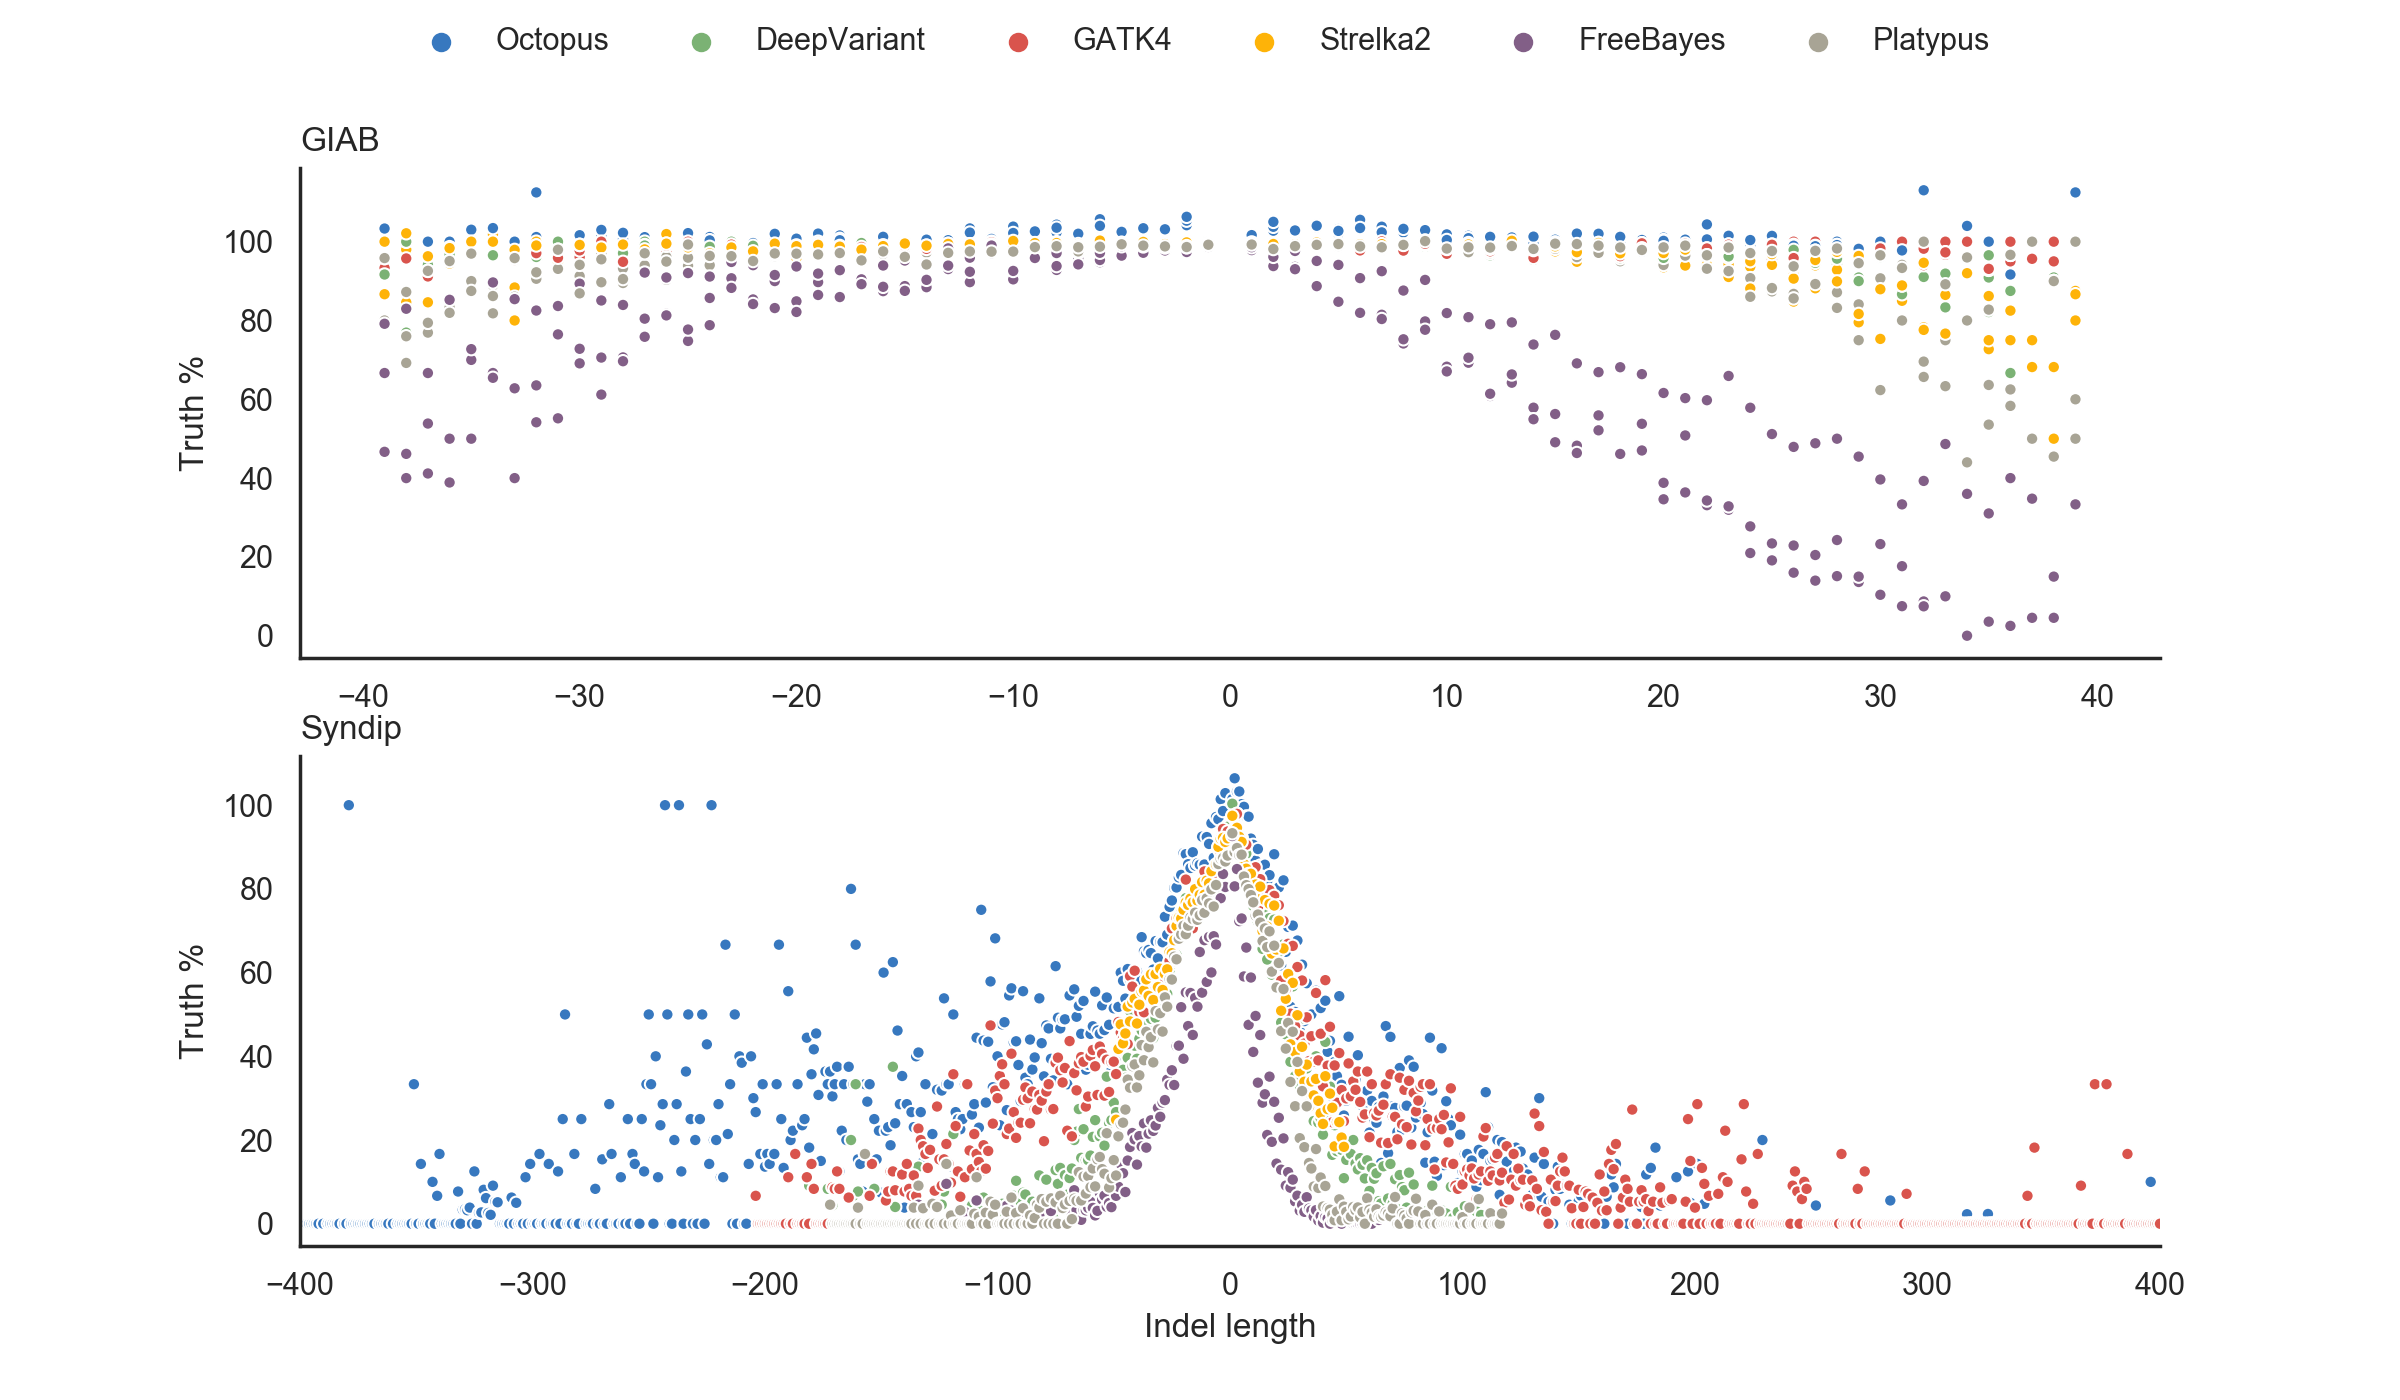

In [391]:
sns.set(style="white")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
g = sns.scatterplot(x="size", y="Truth % change",
                    hue="caller",
                    palette=caller_colours,
                    hue_order=list(reversed(callers)),
                    s=20, marker="o",
                    data=indel_stats_df.query('caller != "Truth" and ((Sample=="HG005" and Library=="GIAB") or (Sample=="HG001" and Library=="pFDA.truth") or (Sample=="HG002" and Library=="pFDA.truth")) and -40 < size < 40 and abs(size) > 0'),
                    ax=axes[0])
g = sns.scatterplot(x="size", y="Truth % change",
                    hue="caller",
                    palette=caller_colours,
                    hue_order=list(reversed(callers)),
                    s=20, marker="o",
                    data=indel_stats_df.query('caller != "Truth" and Sample=="Syndip" and Library=="Broad" and -400 <= size <= 400 and abs(size) > 0'),
                    ax=axes[1])
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                 frameon=False, loc='upper center',
#                  bbox_to_anchor=(0.5, 0.97),
#                  borderaxespad=0,
                 ncol=len(labels)-1)
axes[1].set_xlim(-400, 400)
axes[0].set_title('GIAB', loc='left')
axes[1].set_title('Syndip', loc='left')
axes[0].set(ylabel='Truth %')
axes[1].set(ylabel='Truth %')
axes[0].set(xlabel='')
axes[1].set(xlabel='Indel length')
axes[0].legend_.remove()
axes[1].legend_.remove()
plt.savefig("/Users/dcooke/Documents/octopus-paper/figures/indels.pdf",
            format='pdf', 
            transparent=True,
            bbox_extra_artists=[lgd],
            bbox_inches='tight')

<IPython.core.display.Javascript object>


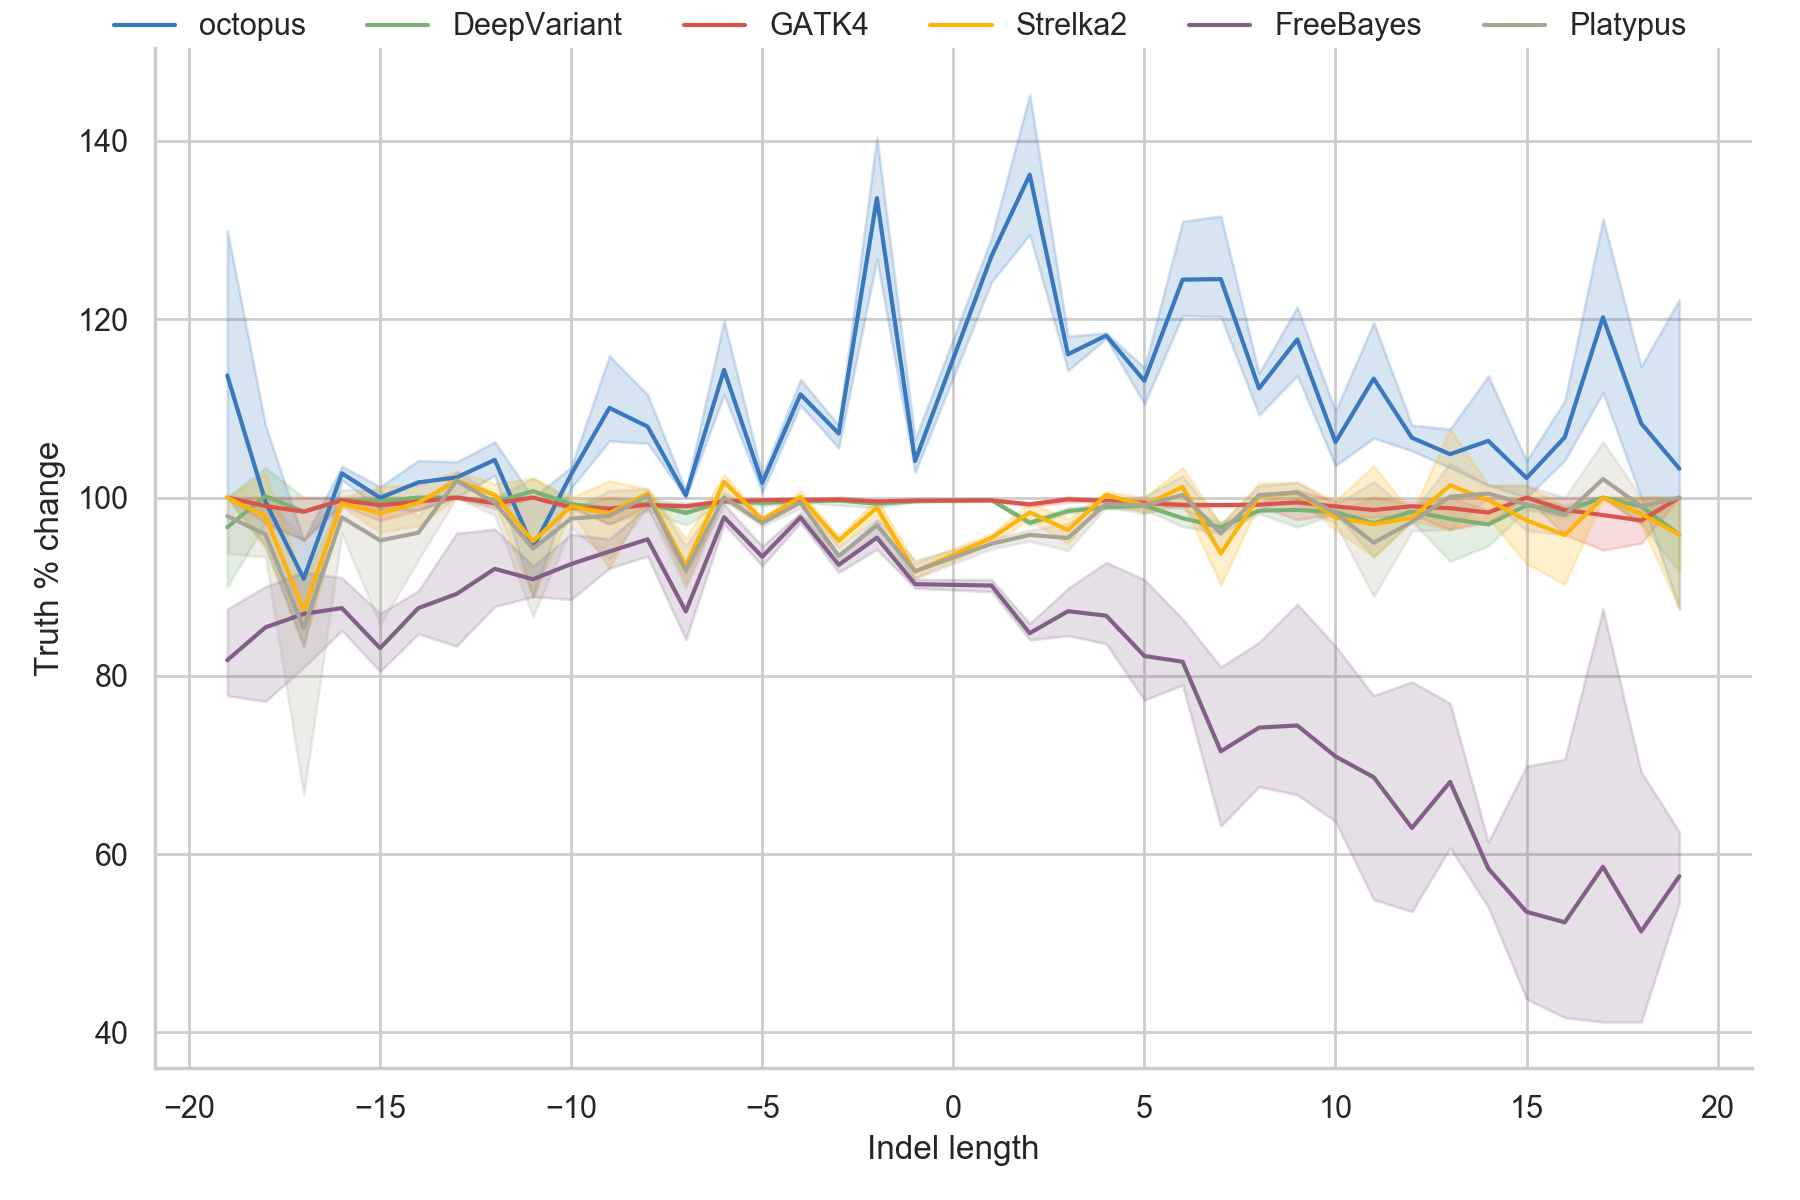

In [364]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.lineplot(x="size", y="Truth % change", hue="caller",
                    palette=caller_colours, hue_order=callers,
#                     s=20, marker="x",
                    data=microsatellites_indel_stats_df.query('caller != "Truth" and ((Sample=="HG005" and Library=="GIAB") or (Sample=="HG001" and Library=="pFDA.truth") or (Sample=="HG002" and Library=="pFDA.truth")) and -20 < size < 20 and abs(size) > 0'),
                    ax=ax)
sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles[1:], labels=labels[1:],
                 frameon=False, loc='upper center',
                 borderaxespad=0, ncol=len(labels)-1)
ax.set(xlabel='Indel length')
ax.legend_.remove()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


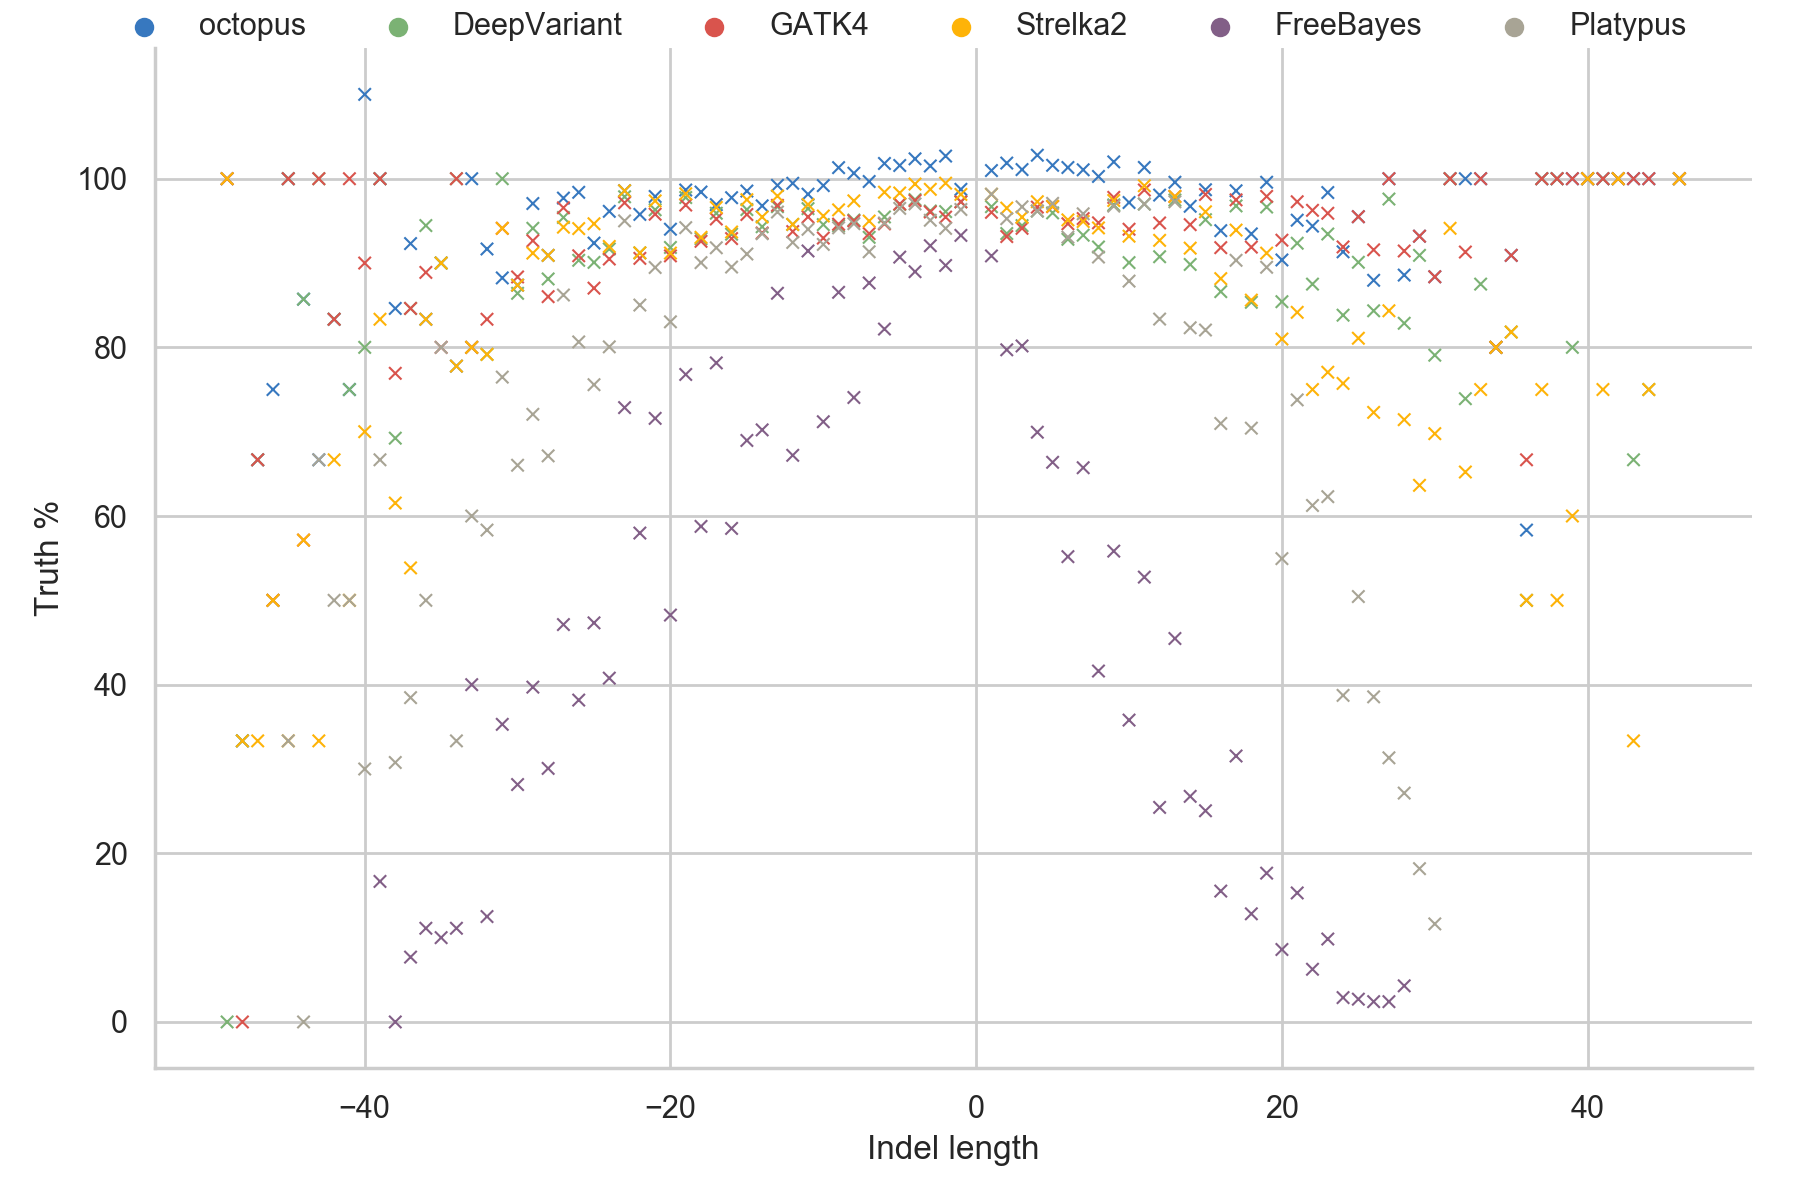

In [350]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.scatterplot(x="size", y="Truth % change", hue="caller",
                    palette=caller_colours,
                    hue_order=list(reversed(callers)),
                    s=20, marker="x",
                    data=indel_stats_df.query('caller != "Truth" and Sample=="HG001" and Library=="platinum" and -50 < size < 50 and abs(size) > 0'),
                    ax=ax, **{'facecolors':'none'})
sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                 frameon=False, loc='upper center',
                 borderaxespad=0, ncol=len(labels)-1)
ax.set(xlabel='Indel length')
ax.set(ylabel='Truth %')
ax.legend_.remove()
plt.tight_layout()
plt.show()